In [1]:
import matplotlib.pyplot as plt
from matplotlib import gridspec
import numpy as np
import scipy.io
import tensorflow as tf
import tensorflow_addons as tfa
import pandas as pd
import os

from tensorflow import keras

from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM, Conv2D
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

c:\Users\ryang\miniconda3\envs\tensorflow\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [2]:
tf.config.list_physical_devices('GPU')
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
label=pd.read_csv('Forest Segmented\meta_data.csv')

classes = {
    '0': (0, 0, 0,),
    '1': (255, 255, 255)
}

print(label)

path_original_images = 'Forest Segmented/images'
path_label_images = 'Forest Segmented/masks'
num_class = 1

print(num_class)

                  image                mask
0      10452_sat_08.jpg   10452_mask_08.jpg
1      10452_sat_18.jpg   10452_mask_18.jpg
2     111335_sat_00.jpg  111335_mask_00.jpg
3     111335_sat_01.jpg  111335_mask_01.jpg
4     111335_sat_02.jpg  111335_mask_02.jpg
...                 ...                 ...
5103  998002_sat_31.jpg  998002_mask_31.jpg
5104  998002_sat_32.jpg  998002_mask_32.jpg
5105  998002_sat_40.jpg  998002_mask_40.jpg
5106  998002_sat_41.jpg  998002_mask_41.jpg
5107  998002_sat_50.jpg  998002_mask_50.jpg

[5108 rows x 2 columns]
1


In [4]:
img, msk = label.items()

In [4]:
def normalize(n):
    return n/255.0

In [6]:
def get_original_images():
    temp_img = []
    for a in range(img[1].shape[0]):
        temp_img.append(tf.keras.preprocessing.image.img_to_array(tf.keras.utils.load_img(f"{path_original_images}/{img[1][a]}", target_size=(128,128))))
    
    return np.array(temp_img)

In [7]:
def classconvert():
    rtn = []
    for a in range(msk[1].shape[0]):
        img_mask = tf.keras.preprocessing.image.img_to_array(tf.keras.utils.load_img(f"{path_label_images}/{msk[1][a]}", target_size=(128,128)))
        temp_mask = np.zeros(shape=(img_mask.shape[0], img_mask.shape[1]), dtype = np.uint32)

        for row in range(img_mask.shape[0]):
            for col in range(img_mask.shape[1]):
                if img_mask[row, col, 0] > 128:
                    temp_mask[row, col] = 1
        temp_mask = np.reshape(temp_mask, (temp_mask.shape[0], temp_mask.shape[1], 1))
        rtn.append(temp_mask)
    return np.array(rtn)

In [8]:
def output_to_image(one_hot):
    img = np.zeros(shape=(one_hot.shape[0], one_hot.shape[1], 3), dtype = np.uint32)
    for row in range(one_hot.shape[0]):
        for col in range(one_hot.shape[1]):
            img[row,col,:] = np.array(classes[str(tf.keras.backend.eval(tf.math.argmax(one_hot[row,col])))])
    return img

In [9]:
def mask_to_image(mask):
    img = np.zeros(shape=(mask.shape[0], mask.shape[1], 3), dtype = np.uint32)
    for row in range(mask.shape[0]):
        for col in range(mask.shape[1]):
            img[row,col,:] = np.array(classes[str(mask[row,col][0])])
    return img

In [10]:
import random

def generate_dataset(dataset, noiseset, noiselevel = 0.2):
    temp = []
    random_indexes = random.sample(range(len(dataset)), int(len(dataset) * noiselevel))
    for i in range(len(dataset)):
        if i in random_indexes:
            temp.append(noiseset[i])
        else:
            temp.append(dataset[i])
    return np.array(temp)

In [11]:
x = normalize(np.load('x.npy'))
y = np.load('y.npy')

x_train = x[0:4086]
y_train = y[0:4086]
x_val = x[4086:5180]
y_val = y[4086:5180]

edge = normalize(np.load("edge.npy"))
hist = normalize(np.load("hist.npy"))
edge_hist = normalize(np.load("edge_hist.npy"))

dataset_edge = edge[0:4086]
dataset_hist = hist[0:4086]
dataset_edge_hist = edge_hist[0:4086]

dataset_edge_val = edge[4086:5180]
dataset_hist_val = hist[4086:5180]
dataset_edge_hist_val = edge_hist[4086:5180]

dataset_noise = normalize(np.load("dataset_noise.npy"))
dataset_edge_noise = normalize(np.load("dataset_edge_noise.npy"))
dataset_hist_noise = normalize(np.load("dataset_hist_noise.npy"))
dataset_all = normalize(np.load("dataset_all.npy"))

dataset_noise_val = x[4086:5180]
dataset_edge_noise_val = edge[4086:5180]
dataset_hist_noise_val = hist[4086:5180]
dataset_all_val = edge_hist[4086:5180]

In [6]:
def conv(input, n):
  x = keras.layers.Conv2D(n, 3, padding='same', activation='relu')(input)
  x = keras.layers.BatchNormalization()(x)

  x = keras.layers.Conv2D(n, 3, padding='same', activation='relu')(x)

  return x

In [7]:
def encoder(input, n, drop):
  x = conv(input, n)
  if drop > 0.0:
    c = keras.layers.Dropout(drop)(x)
    c = keras.layers.MaxPooling2D(pool_size=(2,2))(c)
  else:
    c = keras.layers.MaxPooling2D(pool_size=(2,2))(x)
  return x, c

In [8]:
def decoder(input, concat, n):
  x = keras.layers.Conv2DTranspose(n, (2,2), strides=2, padding='same')(input)
  x = keras.layers.Concatenate()([x, concat])
  x = conv(x, n)
  return x

In [9]:
def build_unet(input_shape, drop):
    inputs = keras.layers.Input(input_shape)

    s1, p1 = encoder(inputs, 64, drop)
    s2, p2 = encoder(p1, 128, drop)
    s3, p3 = encoder(p2, 256, drop)
    s4, p4 = encoder(p3, 512, drop)

    b1 = conv(p4, 1024)

    d1 = decoder(b1, s4, 512)
    d2 = decoder(d1, s3, 256)
    d3 = decoder(d2, s2, 128)
    d4 = decoder(d3, s1, 64)

    outputs = Conv2D(num_class, kernel_size=(3,3), strides=1, padding="same", activation="sigmoid")(d4)

    model = keras.Model(inputs=[inputs], outputs=[outputs], name="U-Net")
    return model

In [17]:
input_shape = (128,128,3)
model_unet = build_unet(input_shape, 0.0)
model_unet.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                             

In [10]:
def shuffle(arr1, arr2):
    randomize = np.arange(len(arr1))
    np.random.shuffle(randomize)
    return arr1[randomize], arr2[randomize]

In [11]:
# Function to calculate Intersection over Union (IoU)
def calculate_iou(y_true, y_pred, smooth=1):
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    iou = (intersection + smooth) / (union + smooth)
    return iou

# Function to calculate Mean Intersection over Union (mIoU)
def calculate_miou(y_true, y_pred, smooth=1):
    iou_foreground = calculate_iou(y_true, y_pred, smooth)
    iou_background = calculate_iou(1 - y_true, 1 - y_pred, smooth)
    miou = (iou_foreground + iou_background) / 2
    return miou

# Function to calculate Dice Coefficient
def calculate_dice(y_true, y_pred, smooth=1):
    intersection = tf.reduce_sum(y_true * y_pred)
    dice = (2 * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)
    return dice

# Custom metric for mIoU
def mean_iou(y_true, y_pred):
    return calculate_miou(y_true, tf.round(y_pred))

# Custom metric for Dice Coefficient
def dice_coef(y_true, y_pred):
    return calculate_dice(y_true, tf.round(y_pred))

In [12]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience = 10, restore_best_weights = True)

In [13]:
batch_s = 32
epoch = 50

change 1-5

In [14]:
iteration = 10

In [15]:
loss = tf.keras.losses.BinaryCrossentropy()

In [24]:
model_unet.compile(loss = loss, optimizer = "adam", metrics = ["accuracy", mean_iou, dice_coef])

check_path = './checkpoint/' + f'{iteration}' + '/model_unet/model_unet_{epoch:04d}_{val_loss:.4f}_{val_accuracy:.4f}_{val_mean_iou:.4f}_{val_dice_coef:.4f}_.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=check_path, monitor='val_dice_coef', mode='max', save_best_only=True, save_weights_only=True)

x_shuffle, y_shuffle = shuffle(x_train, y_train)

results = model_unet.fit(x=x_shuffle, y=y_shuffle, batch_size=batch_s, epochs=epoch, validation_data=(x_val,y_val), callbacks=[checkpoint])
model_unet.save("unet_saved_models/" + f"{iteration}" + "/unet_100_epoch_force.h5")
np.save("history/" + f"{iteration}" + "/unet_history.npy", results.history)

Epoch 1/50
128/128 [==============================] - 37s 208ms/step - loss: 0.5298 - accuracy: 0.7570 - mean_iou: 0.5884 - dice_coef: 0.8079 - val_loss: 88.1377 - val_accuracy: 0.3863 - val_mean_iou: 0.1933 - val_dice_coef: 1.2560e-04
Epoch 2/50
128/128 [==============================] - 20s 160ms/step - loss: 0.4747 - accuracy: 0.7868 - mean_iou: 0.6297 - dice_coef: 0.8302 - val_loss: 6.8981 - val_accuracy: 0.3862 - val_mean_iou: 0.1932 - val_dice_coef: 3.1381e-06
Epoch 3/50
128/128 [==============================] - 21s 160ms/step - loss: 0.4566 - accuracy: 0.7969 - mean_iou: 0.6456 - dice_coef: 0.8387 - val_loss: 4.2998 - val_accuracy: 0.3862 - val_mean_iou: 0.1932 - val_dice_coef: 3.1381e-06
Epoch 4/50
128/128 [==============================] - 21s 161ms/step - loss: 0.4445 - accuracy: 0.8021 - mean_iou: 0.6527 - dice_coef: 0.8428 - val_loss: 1.2911 - val_accuracy: 0.6019 - val_mean_iou: 0.4273 - val_dice_coef: 0.5593
Epoch 5/50
128/128 [==============================] - 21s 161ms

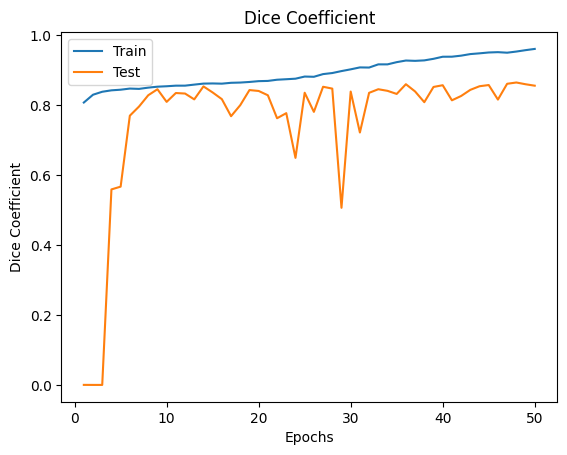

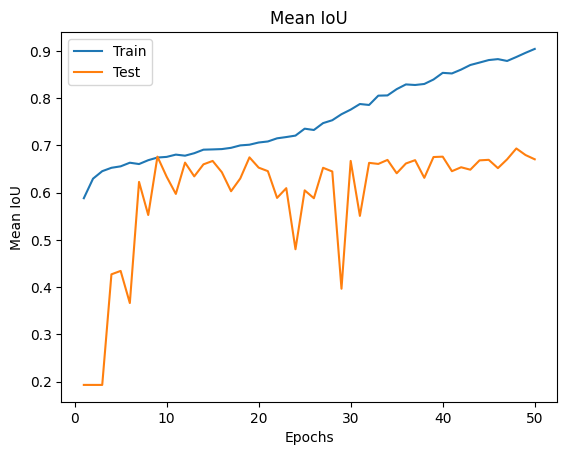

In [25]:
dice = results.history['dice_coef']
val_dice = results.history['val_dice_coef']
epochs = range(1, len(dice) + 1)
plt.plot(epochs, dice, label='Train')
plt.plot(epochs, val_dice, label='Test')
plt.title('Dice Coefficient')
plt.xlabel('Epochs')
plt.ylabel('Dice Coefficient')
plt.legend()
plt.show()

iou = results.history['mean_iou']
val_iou = results.history['val_mean_iou']

plt.plot(epochs, iou, label='Train')
plt.plot(epochs, val_iou, label='Test')
plt.title('Mean IoU')
plt.xlabel('Epochs')
plt.ylabel('Mean IoU')
plt.legend()
plt.show()

In [26]:
input_shape = (128,128,3)
model_unet = build_unet(input_shape, 0.0)

model_unet.compile(loss = loss, optimizer = "adam", metrics = ["accuracy", mean_iou, dice_coef])

check_path = './checkpoint/' + f'{iteration}' + '/model_unet_noise/model_unet_{epoch:04d}_{val_loss:.4f}_{val_accuracy:.4f}_{val_mean_iou:.4f}_{val_dice_coef:.4f}_.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=check_path, monitor='val_dice_coef', mode='max', save_best_only=True, save_weights_only=True)

x_shuffle, y_shuffle = shuffle(dataset_noise, y_train)

results_unet_n = model_unet.fit(x=x_shuffle, y=y_shuffle, batch_size=batch_s, epochs=epoch, validation_data=(dataset_noise_val,y_val), callbacks=[checkpoint])
model_unet.save("unet_saved_models/" + f"{iteration}" + "/noise_100_epoch_force.h5")
np.save("history/" + f"{iteration}" + "/unet_history_n.npy", results_unet_n.history)

Epoch 1/50
128/128 [==============================] - 23s 166ms/step - loss: 0.5264 - accuracy: 0.7576 - mean_iou: 0.5873 - dice_coef: 0.8098 - val_loss: 16.4756 - val_accuracy: 0.3867 - val_mean_iou: 0.1941 - val_dice_coef: 0.0040
Epoch 2/50
128/128 [==============================] - 21s 161ms/step - loss: 0.4761 - accuracy: 0.7847 - mean_iou: 0.6283 - dice_coef: 0.8288 - val_loss: 12.1352 - val_accuracy: 0.3862 - val_mean_iou: 0.1932 - val_dice_coef: 3.1381e-06
Epoch 3/50
128/128 [==============================] - 21s 167ms/step - loss: 0.4558 - accuracy: 0.7945 - mean_iou: 0.6409 - dice_coef: 0.8370 - val_loss: 3.3209 - val_accuracy: 0.3863 - val_mean_iou: 0.1933 - val_dice_coef: 1.8852e-04
Epoch 4/50
128/128 [==============================] - 21s 163ms/step - loss: 0.4441 - accuracy: 0.8018 - mean_iou: 0.6520 - dice_coef: 0.8431 - val_loss: 2.8768 - val_accuracy: 0.4141 - val_mean_iou: 0.2222 - val_dice_coef: 0.0909
Epoch 5/50
128/128 [==============================] - 19s 152ms/st

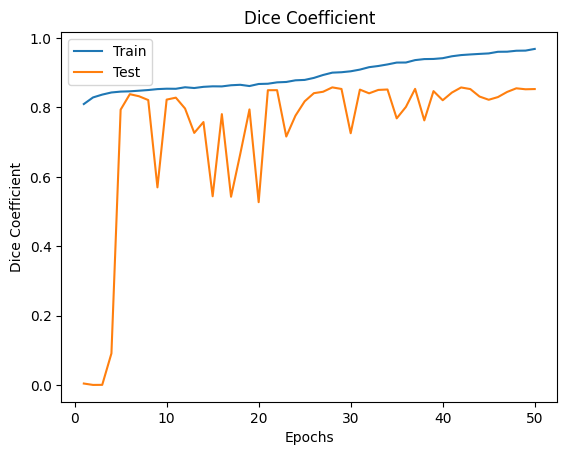

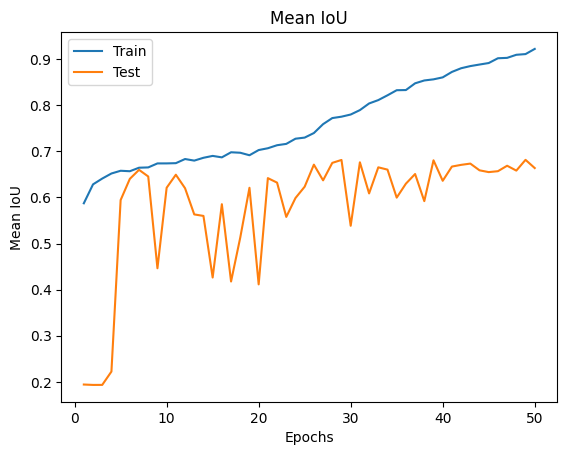

In [27]:
dice = results_unet_n.history['dice_coef']
val_dice = results_unet_n.history['val_dice_coef']
epochs = range(1, len(dice) + 1)
plt.plot(epochs, dice, label='Train')
plt.plot(epochs, val_dice, label='Test')
plt.title('Dice Coefficient')
plt.xlabel('Epochs')
plt.ylabel('Dice Coefficient')
plt.legend()
plt.show()

iou = results_unet_n.history['mean_iou']
val_iou = results_unet_n.history['val_mean_iou']

plt.plot(epochs, iou, label='Train')
plt.plot(epochs, val_iou, label='Test')
plt.title('Mean IoU')
plt.xlabel('Epochs')
plt.ylabel('Mean IoU')
plt.legend()
plt.show()

In [28]:
input_shape = (128,128,3)
model_unet = build_unet(input_shape, 0.0)

model_unet.compile(loss = loss, optimizer = "adam", metrics = ["accuracy", mean_iou, dice_coef])

check_path = './checkpoint/' + f'{iteration}' + '/model_unet_edge/model_unet_{epoch:04d}_{val_loss:.4f}_{val_accuracy:.4f}_{val_mean_iou:.4f}_{val_dice_coef:.4f}_.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=check_path, monitor='val_dice_coef', mode='max', save_best_only=True, save_weights_only=True)

x_shuffle, y_shuffle = shuffle(dataset_edge, y_train)

results_unet_e = model_unet.fit(x=x_shuffle, y=y_shuffle, batch_size=batch_s, epochs=epoch, validation_data=(dataset_edge_val,y_val), callbacks=[checkpoint])
model_unet.save("unet_saved_models/" + f"{iteration}" + "/edge_100_epoch_force.h5")
np.save("history/" + f"{iteration}" + "/unet_history_e.npy", results_unet_e.history)

Epoch 1/50
128/128 [==============================] - 22s 159ms/step - loss: 0.5272 - accuracy: 0.7575 - mean_iou: 0.5891 - dice_coef: 0.8087 - val_loss: 21.2896 - val_accuracy: 0.3862 - val_mean_iou: 0.1932 - val_dice_coef: 3.1381e-06
Epoch 2/50
128/128 [==============================] - 19s 152ms/step - loss: 0.4822 - accuracy: 0.7822 - mean_iou: 0.6240 - dice_coef: 0.8279 - val_loss: 4.6539 - val_accuracy: 0.3862 - val_mean_iou: 0.1932 - val_dice_coef: 3.1381e-06
Epoch 3/50
128/128 [==============================] - 20s 154ms/step - loss: 0.4662 - accuracy: 0.7909 - mean_iou: 0.6367 - dice_coef: 0.8342 - val_loss: 5.0026 - val_accuracy: 0.3862 - val_mean_iou: 0.1932 - val_dice_coef: 5.0902e-06
Epoch 4/50
128/128 [==============================] - 20s 154ms/step - loss: 0.4498 - accuracy: 0.7995 - mean_iou: 0.6496 - dice_coef: 0.8398 - val_loss: 1.0334 - val_accuracy: 0.5851 - val_mean_iou: 0.4071 - val_dice_coef: 0.5137
Epoch 5/50
128/128 [==============================] - 20s 159ms

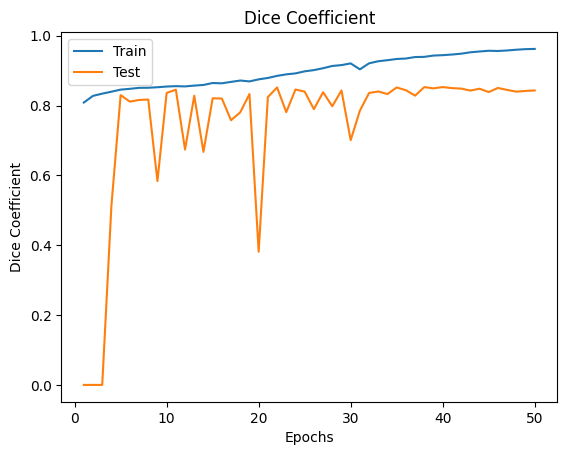

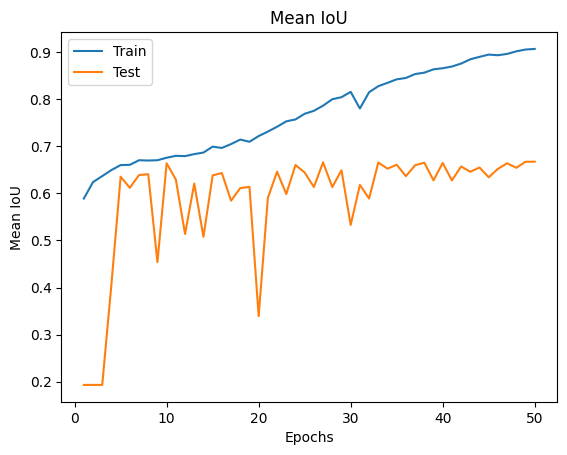

In [29]:
dice = results_unet_e.history['dice_coef']
val_dice = results_unet_e.history['val_dice_coef']
epochs = range(1, len(dice) + 1)
plt.plot(epochs, dice, label='Train')
plt.plot(epochs, val_dice, label='Test')
plt.title('Dice Coefficient')
plt.xlabel('Epochs')
plt.ylabel('Dice Coefficient')
plt.legend()
plt.show()

iou = results_unet_e.history['mean_iou']
val_iou = results_unet_e.history['val_mean_iou']

plt.plot(epochs, iou, label='Train')
plt.plot(epochs, val_iou, label='Test')
plt.title('Mean IoU')
plt.xlabel('Epochs')
plt.ylabel('Mean IoU')
plt.legend()
plt.show()

In [30]:
input_shape = (128,128,3)
model_unet = build_unet(input_shape, 0.0)

model_unet.compile(loss = loss, optimizer = "adam", metrics = ["accuracy", mean_iou, dice_coef])

check_path = './checkpoint/' + f'{iteration}' + '/model_unet_hist/model_unet_{epoch:04d}_{val_loss:.4f}_{val_accuracy:.4f}_{val_mean_iou:.4f}_{val_dice_coef:.4f}_.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=check_path, monitor='val_dice_coef', mode='max', save_best_only=True, save_weights_only=True)

x_shuffle, y_shuffle = shuffle(dataset_hist, y_train)

results_unet_h = model_unet.fit(x=x_shuffle, y=y_shuffle, batch_size=batch_s, epochs=epoch, validation_data=(dataset_hist_val,y_val), callbacks=[checkpoint])
model_unet.save("unet_saved_models/" + f"{iteration}" + "/hist_100_epoch_force.h5")
np.save("history/" + f"{iteration}" + "/unet_history_h.npy", results_unet_h.history)

Epoch 1/50
128/128 [==============================] - 25s 187ms/step - loss: 0.5418 - accuracy: 0.7455 - mean_iou: 0.5723 - dice_coef: 0.8002 - val_loss: 41.8304 - val_accuracy: 0.3862 - val_mean_iou: 0.1932 - val_dice_coef: 3.1381e-06
Epoch 2/50
128/128 [==============================] - 23s 180ms/step - loss: 0.4947 - accuracy: 0.7705 - mean_iou: 0.6062 - dice_coef: 0.8197 - val_loss: 13.8080 - val_accuracy: 0.3862 - val_mean_iou: 0.1932 - val_dice_coef: 3.1381e-06
Epoch 3/50
128/128 [==============================] - 22s 174ms/step - loss: 0.4835 - accuracy: 0.7782 - mean_iou: 0.6182 - dice_coef: 0.8245 - val_loss: 4.1763 - val_accuracy: 0.3862 - val_mean_iou: 0.1932 - val_dice_coef: 3.1381e-06
Epoch 4/50
128/128 [==============================] - 22s 173ms/step - loss: 0.4720 - accuracy: 0.7867 - mean_iou: 0.6310 - dice_coef: 0.8311 - val_loss: 1.5939 - val_accuracy: 0.3987 - val_mean_iou: 0.2061 - val_dice_coef: 0.0411
Epoch 5/50
128/128 [==============================] - 22s 171m

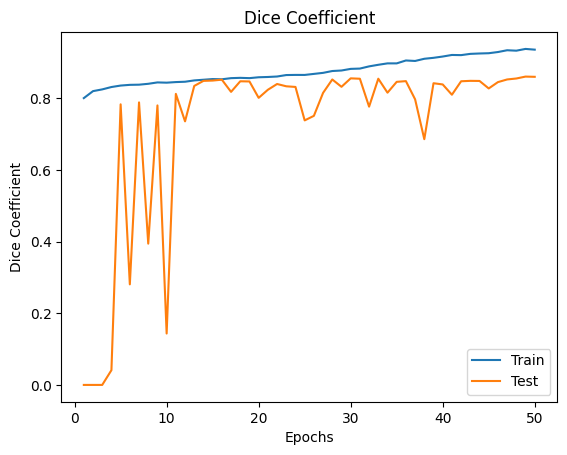

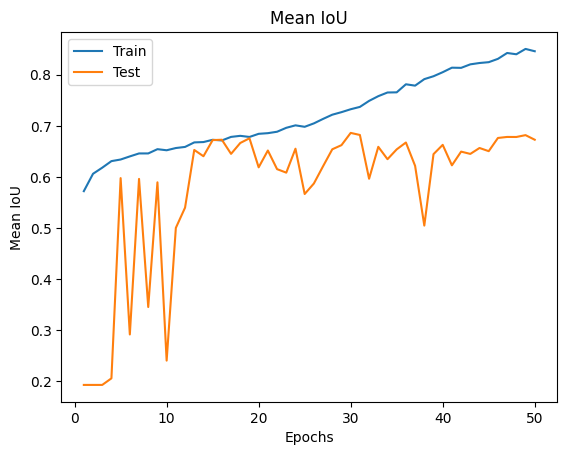

In [31]:
dice = results_unet_h.history['dice_coef']
val_dice = results_unet_h.history['val_dice_coef']
epochs = range(1, len(dice) + 1)
plt.plot(epochs, dice, label='Train')
plt.plot(epochs, val_dice, label='Test')
plt.title('Dice Coefficient')
plt.xlabel('Epochs')
plt.ylabel('Dice Coefficient')
plt.legend()
plt.show()

iou = results_unet_h.history['mean_iou']
val_iou = results_unet_h.history['val_mean_iou']

plt.plot(epochs, iou, label='Train')
plt.plot(epochs, val_iou, label='Test')
plt.title('Mean IoU')
plt.xlabel('Epochs')
plt.ylabel('Mean IoU')
plt.legend()
plt.show()

In [32]:
input_shape = (128,128,3)
model_unet = build_unet(input_shape, 0.0)

model_unet.compile(loss = loss, optimizer = "adam", metrics = ["accuracy", mean_iou, dice_coef])

check_path = './checkpoint/' + f'{iteration}' + '/model_unet_noise_edge/model_unet_{epoch:04d}_{val_loss:.4f}_{val_accuracy:.4f}_{val_mean_iou:.4f}_{val_dice_coef:.4f}_.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=check_path, monitor='val_dice_coef', mode='max', save_best_only=True, save_weights_only=True)

x_shuffle, y_shuffle = shuffle(dataset_edge_noise, y_train)

results_unet_ne = model_unet.fit(x=x_shuffle, y=y_shuffle, batch_size=batch_s, epochs=epoch, validation_data=(dataset_edge_noise_val,y_val), callbacks=[checkpoint])
model_unet.save("unet_saved_models/" + f"{iteration}" + "/edge_noise_100_epoch_force.h5")
np.save("history/" + f"{iteration}" + "/net_history_ne.npy", results_unet_ne.history)

Epoch 1/50
128/128 [==============================] - 28s 206ms/step - loss: 0.5225 - accuracy: 0.7581 - mean_iou: 0.5903 - dice_coef: 0.8096 - val_loss: 3.5256 - val_accuracy: 0.3862 - val_mean_iou: 0.1932 - val_dice_coef: 3.1381e-06
Epoch 2/50
128/128 [==============================] - 25s 198ms/step - loss: 0.4771 - accuracy: 0.7845 - mean_iou: 0.6281 - dice_coef: 0.8281 - val_loss: 7.8291 - val_accuracy: 0.3862 - val_mean_iou: 0.1932 - val_dice_coef: 3.1381e-06
Epoch 3/50
128/128 [==============================] - 26s 201ms/step - loss: 0.4606 - accuracy: 0.7906 - mean_iou: 0.6357 - dice_coef: 0.8337 - val_loss: 7.9840 - val_accuracy: 0.3862 - val_mean_iou: 0.1932 - val_dice_coef: 3.5809e-06
Epoch 4/50
128/128 [==============================] - 26s 200ms/step - loss: 0.4585 - accuracy: 0.7931 - mean_iou: 0.6396 - dice_coef: 0.8360 - val_loss: 3.3552 - val_accuracy: 0.4339 - val_mean_iou: 0.2430 - val_dice_coef: 0.1500
Epoch 5/50
128/128 [==============================] - 26s 201ms/

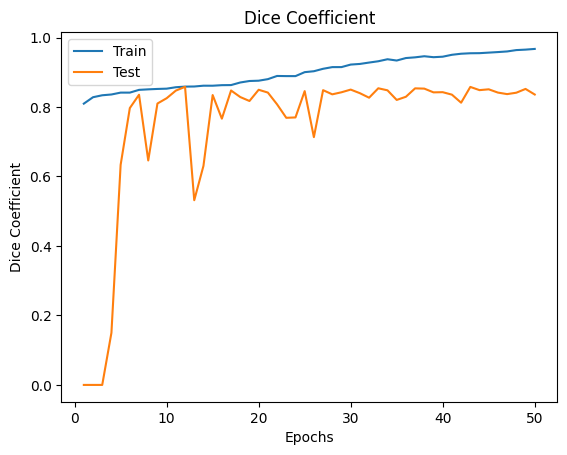

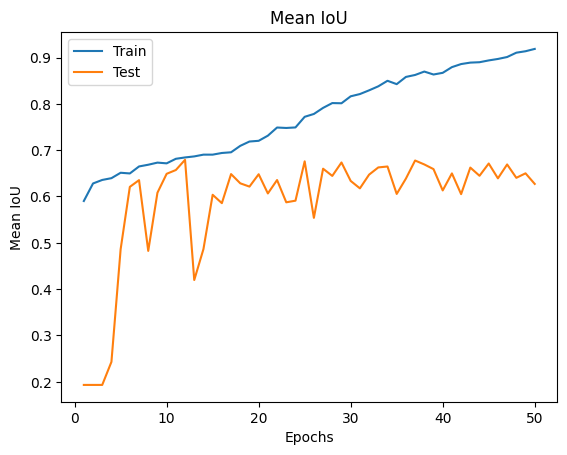

In [33]:
dice = results_unet_ne.history['dice_coef']
val_dice = results_unet_ne.history['val_dice_coef']
epochs = range(1, len(dice) + 1)
plt.plot(epochs, dice, label='Train')
plt.plot(epochs, val_dice, label='Test')
plt.title('Dice Coefficient')
plt.xlabel('Epochs')
plt.ylabel('Dice Coefficient')
plt.legend()
plt.show()

iou = results_unet_ne.history['mean_iou']
val_iou = results_unet_ne.history['val_mean_iou']

plt.plot(epochs, iou, label='Train')
plt.plot(epochs, val_iou, label='Test')
plt.title('Mean IoU')
plt.xlabel('Epochs')
plt.ylabel('Mean IoU')
plt.legend()
plt.show()

In [50]:
input_shape = (128,128,3)
model_unet = build_unet(input_shape, 0.0)

model_unet.compile(loss = loss, optimizer = "adam", metrics = ["accuracy", mean_iou, dice_coef])

check_path = './checkpoint/' + f'{iteration}' + '/model_unet_noise_hist/model_unet_{epoch:04d}_{val_loss:.4f}_{val_accuracy:.4f}_{val_mean_iou:.4f}_{val_dice_coef:.4f}_.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=check_path, monitor='val_dice_coef', mode='max', save_best_only=True, save_weights_only=True)

x_shuffle, y_shuffle = shuffle(dataset_hist_noise, y_train)

results_unet_nh = model_unet.fit(x=x_shuffle, y=y_shuffle, batch_size=batch_s, epochs=epoch, validation_data=(dataset_hist_noise_val,y_val), callbacks=[checkpoint])
model_unet.save("unet_saved_models/" + f"{iteration}" + "/noise_hist_100_epoch_force.h5")
np.save("history/" + f"{iteration}" + "/unet_history_nh.npy", results_unet_nh.history)

Epoch 1/50
128/128 [==============================] - 22s 159ms/step - loss: 0.5434 - accuracy: 0.7449 - mean_iou: 0.5673 - dice_coef: 0.7994 - val_loss: 22.3017 - val_accuracy: 0.3863 - val_mean_iou: 0.1933 - val_dice_coef: 1.2575e-04
Epoch 2/50
128/128 [==============================] - 20s 158ms/step - loss: 0.4931 - accuracy: 0.7731 - mean_iou: 0.6113 - dice_coef: 0.8202 - val_loss: 7.2375 - val_accuracy: 0.3862 - val_mean_iou: 0.1932 - val_dice_coef: 3.1381e-06
Epoch 3/50
128/128 [==============================] - 21s 161ms/step - loss: 0.4801 - accuracy: 0.7805 - mean_iou: 0.6202 - dice_coef: 0.8280 - val_loss: 3.6967 - val_accuracy: 0.3863 - val_mean_iou: 0.1933 - val_dice_coef: 2.6931e-04
Epoch 4/50
128/128 [==============================] - 21s 164ms/step - loss: 0.4631 - accuracy: 0.7906 - mean_iou: 0.6363 - dice_coef: 0.8341 - val_loss: 2.1990 - val_accuracy: 0.3868 - val_mean_iou: 0.1937 - val_dice_coef: 0.0016
Epoch 5/50
128/128 [==============================] - 22s 169ms

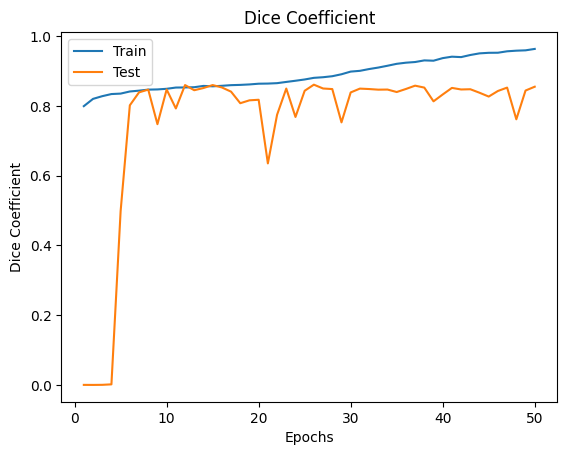

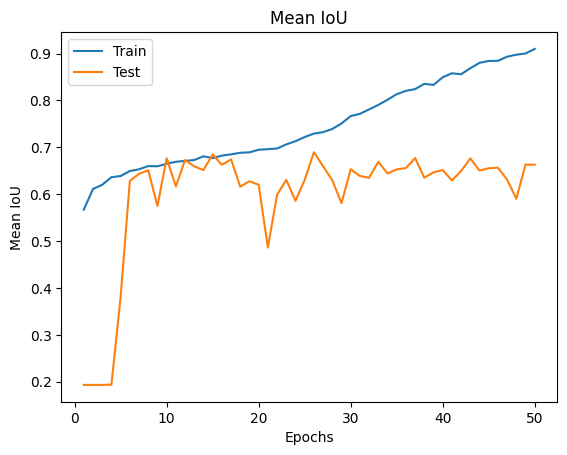

In [51]:
dice = results_unet_nh.history['dice_coef']
val_dice = results_unet_nh.history['val_dice_coef']
epochs = range(1, len(dice) + 1)
plt.plot(epochs, dice, label='Train')
plt.plot(epochs, val_dice, label='Test')
plt.title('Dice Coefficient')
plt.xlabel('Epochs')
plt.ylabel('Dice Coefficient')
plt.legend()
plt.show()

iou = results_unet_nh.history['mean_iou']
val_iou = results_unet_nh.history['val_mean_iou']

plt.plot(epochs, iou, label='Train')
plt.plot(epochs, val_iou, label='Test')
plt.title('Mean IoU')
plt.xlabel('Epochs')
plt.ylabel('Mean IoU')
plt.legend()
plt.show()

In [16]:
input_shape = (128,128,3)
model_unet = build_unet(input_shape, 0.0)

model_unet.compile(loss = loss, optimizer = "adam", metrics = ["accuracy", mean_iou, dice_coef])

check_path = './checkpoint/' + f'{iteration}' + '/model_unet_edge_hist/model_unet_{epoch:04d}_{val_loss:.4f}_{val_accuracy:.4f}_{val_mean_iou:.4f}_{val_dice_coef:.4f}_.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=check_path, monitor='val_dice_coef', mode='max', save_best_only=True, save_weights_only=True)

x_shuffle, y_shuffle = shuffle(dataset_edge_hist, y_train)

results_unet_eh = model_unet.fit(x=x_shuffle, y=y_shuffle, batch_size=batch_s, epochs=epoch, validation_data=(dataset_edge_hist_val,y_val), callbacks=[checkpoint])
model_unet.save("unet_saved_models/" + f"{iteration}" + "/edge_hist_100_epoch_force.h5")
np.save("history/" + f"{iteration}" + "/unet_history_eh.npy", results_unet_eh.history)

Epoch 1/50
128/128 [==============================] - 35s 196ms/step - loss: 0.5561 - accuracy: 0.7324 - mean_iou: 0.5530 - dice_coef: 0.7923 - val_loss: 31.2664 - val_accuracy: 0.3862 - val_mean_iou: 0.1932 - val_dice_coef: 3.1381e-06
Epoch 2/50
128/128 [==============================] - 19s 150ms/step - loss: 0.5109 - accuracy: 0.7609 - mean_iou: 0.5936 - dice_coef: 0.8124 - val_loss: 6.5033 - val_accuracy: 0.3862 - val_mean_iou: 0.1932 - val_dice_coef: 3.1381e-06
Epoch 3/50
128/128 [==============================] - 19s 150ms/step - loss: 0.4845 - accuracy: 0.7746 - mean_iou: 0.6137 - dice_coef: 0.8208 - val_loss: 4.7630 - val_accuracy: 0.3862 - val_mean_iou: 0.1932 - val_dice_coef: 3.1381e-06
Epoch 4/50
128/128 [==============================] - 19s 151ms/step - loss: 0.4727 - accuracy: 0.7835 - mean_iou: 0.6245 - dice_coef: 0.8281 - val_loss: 1.1573 - val_accuracy: 0.4888 - val_mean_iou: 0.3034 - val_dice_coef: 0.3115
Epoch 5/50
128/128 [==============================] - 19s 151ms

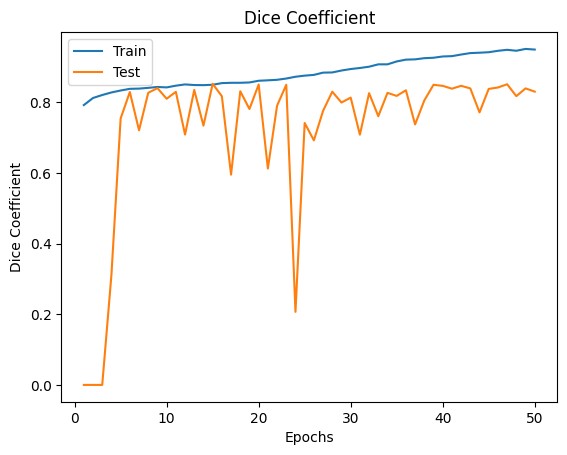

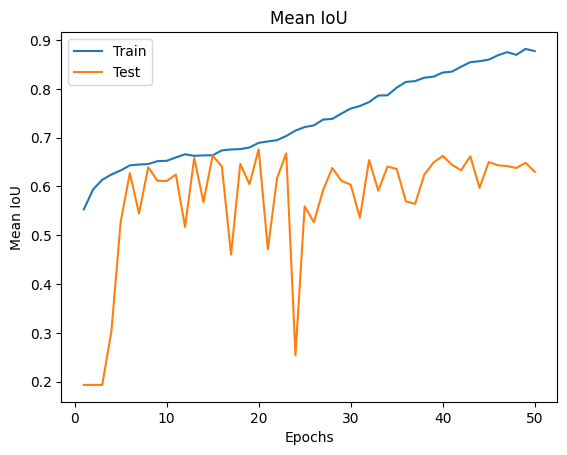

In [17]:
dice = results_unet_eh.history['dice_coef']
val_dice = results_unet_eh.history['val_dice_coef']
epochs = range(1, len(dice) + 1)
plt.plot(epochs, dice, label='Train')
plt.plot(epochs, val_dice, label='Test')
plt.title('Dice Coefficient')
plt.xlabel('Epochs')
plt.ylabel('Dice Coefficient')
plt.legend()
plt.show()

iou = results_unet_eh.history['mean_iou']
val_iou = results_unet_eh.history['val_mean_iou']

plt.plot(epochs, iou, label='Train')
plt.plot(epochs, val_iou, label='Test')
plt.title('Mean IoU')
plt.xlabel('Epochs')
plt.ylabel('Mean IoU')
plt.legend()
plt.show()

In [18]:
input_shape = (128,128,3)
model_unet = build_unet(input_shape, 0.0)

model_unet.compile(loss = loss, optimizer = "adam", metrics = ["accuracy", mean_iou, dice_coef])

check_path = './checkpoint/' + f'{iteration}' + '/model_unet_all/model_unet_{epoch:04d}_{val_loss:.4f}_{val_accuracy:.4f}_{val_mean_iou:.4f}_{val_dice_coef:.4f}_.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=check_path, monitor='val_dice_coef', mode='max', save_best_only=True, save_weights_only=True)

x_shuffle, y_shuffle = shuffle(dataset_all, y_train)

results_unet_all = model_unet.fit(x=x_shuffle, y=y_shuffle, batch_size=batch_s, epochs=epoch, validation_data=(dataset_all_val,y_val), callbacks=[checkpoint])
model_unet.save("unet_saved_models/" + f"{iteration}" + "/all_100_epoch_force.h5")
np.save("history/" + f"{iteration}" + "/unet_history_all.npy", results_unet_all.history)

Epoch 1/50
128/128 [==============================] - 21s 154ms/step - loss: 0.5270 - accuracy: 0.7509 - mean_iou: 0.5799 - dice_coef: 0.8018 - val_loss: 21.4678 - val_accuracy: 0.3862 - val_mean_iou: 0.1932 - val_dice_coef: 3.1381e-06
Epoch 2/50
128/128 [==============================] - 19s 152ms/step - loss: 0.4845 - accuracy: 0.7792 - mean_iou: 0.6212 - dice_coef: 0.8249 - val_loss: 2.4933 - val_accuracy: 0.3862 - val_mean_iou: 0.1932 - val_dice_coef: 4.6192e-06
Epoch 3/50
128/128 [==============================] - 19s 151ms/step - loss: 0.4737 - accuracy: 0.7865 - mean_iou: 0.6292 - dice_coef: 0.8314 - val_loss: 5.4246 - val_accuracy: 0.3862 - val_mean_iou: 0.1932 - val_dice_coef: 3.1381e-06
Epoch 4/50
128/128 [==============================] - 19s 152ms/step - loss: 0.4533 - accuracy: 0.7949 - mean_iou: 0.6407 - dice_coef: 0.8382 - val_loss: 1.0379 - val_accuracy: 0.6052 - val_mean_iou: 0.4312 - val_dice_coef: 0.5630
Epoch 5/50
128/128 [==============================] - 19s 152ms

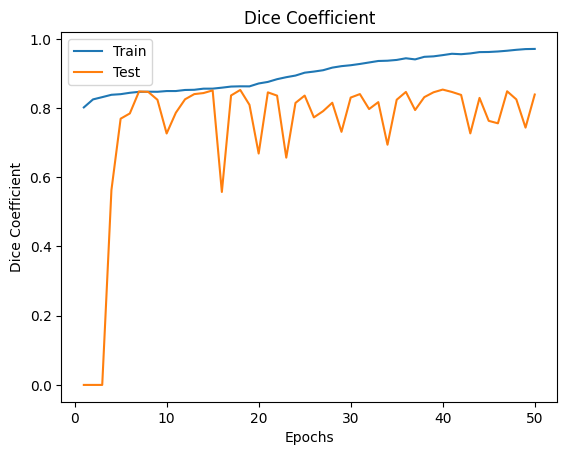

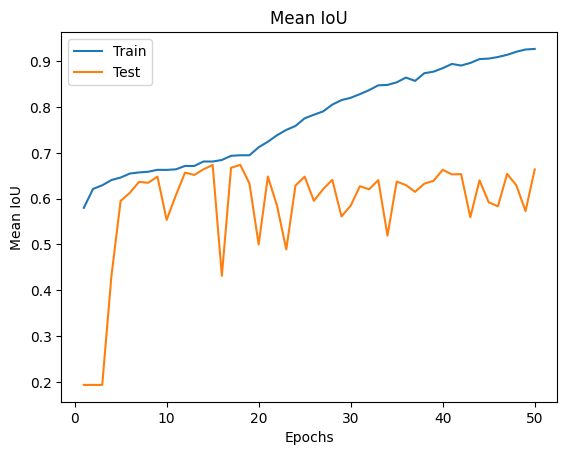

In [19]:
dice = results_unet_all.history['dice_coef']
val_dice = results_unet_all.history['val_dice_coef']
epochs = range(1, len(dice) + 1)
plt.plot(epochs, dice, label='Train')
plt.plot(epochs, val_dice, label='Test')
plt.title('Dice Coefficient')
plt.xlabel('Epochs')
plt.ylabel('Dice Coefficient')
plt.legend()
plt.show()

iou = results_unet_all.history['mean_iou']
val_iou = results_unet_all.history['val_mean_iou']

plt.plot(epochs, iou, label='Train')
plt.plot(epochs, val_iou, label='Test')
plt.title('Mean IoU')
plt.xlabel('Epochs')
plt.ylabel('Mean IoU')
plt.legend()
plt.show()